## ImageNet 

In [5]:
import timm
import time 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from medmnist import INFO
import numpy as np
import faiss
import copy
from tqdm import tqdm

from torch.nn.functional import softmax, cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import clip

import warnings
warnings.filterwarnings("ignore")

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda:0


In [7]:
import json
import urllib.request

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = urllib.request.urlopen(url).read().decode().splitlines()
print(imagenet_classes[0])

tench


### Dataset Loading 

In [8]:
import os
from torchvision import datasets, transforms
import torch

print(f"Step 1: Loading dataset with resize transform...")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]) 
])

val_data_dir = 'dataset/imagenet_validation' 
test_data_dir = 'dataset/imagenet_tests'

val_dataset = datasets.ImageFolder(os.path.join(val_data_dir), transform=transform) 

test_datasets = {
    f'test{i}': datasets.ImageFolder(os.path.join(test_data_dir, f'test{i}'), transform=transform)
    for i in range(1, 11)
}

print(f"Validation samples: {len(val_dataset)}")
print(f"Validation samples: {len(test_datasets['test1'])}")

Step 1: Loading dataset with resize transform...
Validation samples: 30000
Validation samples: 2004


In [9]:
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4) 
test_loader = DataLoader(test_datasets['test1'], batch_size=1, shuffle=False, num_workers=4)  

## Base Models 

In [10]:
from torchvision.models import (
    resnet18, resnet34,  
    resnet50, resnet101, resnet152, vgg11, vgg19,
    densenet201, inception_v3, googlenet, efficientnet_b0, efficientnet_b7,
    squeezenet1_1, shufflenet_v2_x1_0, mobilenet_v2, convnext_tiny
)
from torchvision.models.vision_transformer import vit_b_16, vit_l_16 
import timm  

## Helper Models 

In [11]:
def visualize_test_and_roc(test_img, roc_imgs, local_labels, class_names=None):
    def denormalize(img_tensor, mean, std):
        mean = torch.tensor(mean).view(-1, 1, 1).to(img_tensor.device)
        std = torch.tensor(std).view(-1, 1, 1).to(img_tensor.device)
        return img_tensor * std + mean

    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225] 

    k = roc_imgs.size(0)
    ncols = min(k, 5)
    nrows = 1 + (k + ncols - 1) // ncols  # one row for test image + RoC images
    
    plt.figure(figsize=(3 * ncols, 3 * nrows))
    
    # Plot test image
    plt.subplot(nrows, ncols, 1)
    denorm_img = denormalize(test_img, mean, std).clamp(0, 1)
    img_np = TF.to_pil_image(denorm_img.cpu())
    plt.imshow(img_np)
    plt.title("Test Image")
    plt.axis("off")
    
    # Plot RoC images
    for i in range(k):
        plt.subplot(nrows, ncols, i + 2)
        denorm_img = denormalize(roc_imgs[i], mean, std).clamp(0, 1)
        img_np = TF.to_pil_image(denorm_img.cpu())
        label = local_labels[i]
        if class_names:
            label = class_names[label]
        plt.imshow(img_np)
        plt.title(f"RoC #{i+1}\nLabel: {label}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [12]:
def get_last_linear_layer(model):
    """
    Try to find the last Linear layer in the model,
    using common attribute names and fallback to scanning modules.
    """
    name = model.__class__.__name__.lower()

    # Common last layer attribute names to try (ViT, EfficientNet, etc)
    candidate_attrs = ['head', 'heads', 'classifier', 'fc', 'mlp_head']

    for attr in candidate_attrs:
        if hasattr(model, attr):
            layer = getattr(model, attr)
            # If it's directly a Linear layer
            if isinstance(layer, nn.Linear):
                return layer
            # If Sequential or Module, find last Linear inside it
            if isinstance(layer, nn.Sequential) or isinstance(layer, nn.Module):
                # Find last Linear inside this attribute recursively
                last_linear = None
                for child in reversed(list(layer.modules())):
                    if isinstance(child, nn.Linear):
                        last_linear = child
                        break
                if last_linear is not None:
                    return last_linear

    # Fallback: scan all modules and pick the last Linear
    last_linear = None
    for m in model.modules():
        if isinstance(m, nn.Linear):
            last_linear = m
    if last_linear is not None:
        return last_linear

    raise RuntimeError("No Linear layer found in model")


def get_features_before_last_linear(model, x):
    features = {}

    def find_last_linear(module):
        last_linear = None
        for m in module.modules():
            if isinstance(m, torch.nn.Linear):
                last_linear = m
        return last_linear

    last_linear = find_last_linear(model)
    if last_linear is None:
        raise RuntimeError("No Linear layer found in model")

    def hook(module, input, output):
        features['feat'] = input[0].detach()

    handle = last_linear.register_forward_hook(hook)

    model.eval()
    with torch.no_grad():
        _ = model(x)

    handle.remove()

    if 'feat' not in features:
        raise RuntimeError("Failed to capture features from last linear layer")

    return features['feat']

In [13]:
def fire_check(local_labels, preds, per_class_min=1):
    local_labels = np.asarray(local_labels)

    # If preds are logits/probs, convert to labels
    preds = np.asarray(preds)
    if preds.ndim > 1:
        preds = preds.argmax(axis=1)

    # Classes present in the RoC (unique, not repeated)
    classes_in_roc = np.unique(local_labels)

    # Check: for each class c in RoC, there is at least `per_class_min` correct prediction
    missing = []
    for c in classes_in_roc:
        mask = (local_labels == c)
        n_correct = int(np.sum(preds[mask] == c))
        if n_correct < per_class_min:
            missing.append((int(c), n_correct))  # track which class is short

    fire_ok = (len(missing) == 0)
    return fire_ok

## VisionDES 

In [14]:

class VisionDES: 
    def __init__(self, dsel_dataset, pool): 
        self.dsel_dataset = dsel_dataset
        self.dsel_loader = DataLoader(dsel_dataset, batch_size=32, shuffle=False) 
        self.dino_model = timm.create_model('vit_base_patch16_224.dino', pretrained=True).to(device)
        self.dino_model.eval()  
        self.pool = pool 

        self.suspected_model_votes = [] 
        
        
    def dino_embedder(self, images):
        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)
        return self.dino_model.forward_features(images)


    def fit(self): 
        dsel_embeddings = []
        dsel_labels = []
    
        with torch.no_grad():
            for imgs, labels in tqdm(self.dsel_loader):
                imgs = imgs.to(device)
                embs = self.dino_embedder(imgs).cpu()  
                dsel_embeddings.append(embs)
                dsel_labels.append(labels)
    
        # Keep as tensor
        dsel_embeddings_tensor = torch.cat(dsel_embeddings).detach().cpu()  
        cls_tensor = dsel_embeddings_tensor[:, 0, :]  
    
        # Convert to NumPy
        cls_embeddings = np.ascontiguousarray(cls_tensor.numpy(), dtype='float32')
        self.dsel_embeddings = cls_embeddings
        self.dsel_labels = torch.cat(dsel_labels).numpy()
    
        # Build FAISS index
        embedding_dim = cls_embeddings.shape[1]
        self.index = faiss.IndexFlatL2(embedding_dim)
        self.index.add(cls_embeddings)

    
    def get_output_size(self, model):
        """
        Returns the output size (number of classes) from various model architectures.
        """
        if hasattr(model, 'fc'):
            return model.fc.out_features
        elif hasattr(model, 'classifier'):
            if isinstance(model.classifier, nn.Sequential):
                return model.classifier[-1].out_features
            else:
                return model.classifier.out_features
        elif hasattr(model, 'heads'):  # ViT / DINO from torchvision
            return model.heads.head.out_features
        elif hasattr(model, 'head'):  # ViT/Swin from timm
            return model.head.out_features
        else:
            raise AttributeError("Cannot determine output size of the model.")


    def predict_weighted_robust(self, test_img, k=7, return_logits=False, explain=False, top=False, n=3, use_fire=False, per_class_min=1, 
                                use_sim=False, sim_threshold=0, alpha=0.6, knorae=False):
        # Step 1: Get DINO CLS embedding for the test image
        img_for_dino = test_img.unsqueeze(0).to(device)

        with torch.no_grad():
            test_emb = self.dino_model.forward_features(img_for_dino).cpu().numpy().astype('float32')
            test_emb = test_emb[:, 0, :]  # CLS token only
    
        # Step 2: Find k nearest neighbors in FAISS (Region of Competence)
        distances, neighbors = self.index.search(test_emb, k)
        neighbor_idxs = neighbors[0]
        local_labels = self.dsel_labels[neighbor_idxs]
        local_labels = np.array(local_labels).flatten()
    
        # Step 3: Get RoC images
        with torch.no_grad():
            roc_imgs = torch.stack([self.dsel_dataset[idx][0] for idx in neighbor_idxs]).to(device)
    
        # Step 4: Evaluate classifiers — compute competence and feature similarity
        competences, soft_outputs, feature_similarities, passed_fire, correct_counts = [], [], [], [], []
    
        test_img_batch = test_img.unsqueeze(0).to(device)
    
        for clf in self.pool:
            clf.eval()
            with torch.no_grad():
                outputs = clf(roc_imgs)
                preds = outputs.argmax(dim=1).cpu().numpy()
                correct = (preds == local_labels).sum()
                competence = correct / k
                competences.append(competence)
                correct_counts.append(correct)

                # 🔥 FIRE check: at least one correct per class
                fire_ok = fire_check(local_labels, preds, per_class_min=per_class_min) 
                passed_fire.append(fire_ok)

                logits = clf(test_img.unsqueeze(0).to(device)).squeeze(0)
                probs = softmax(logits, dim=0)
                soft_outputs.append(probs)

                # Feature similarity using ResNet embeddings
                test_feat = get_features_before_last_linear(clf, test_img.unsqueeze(0).to(device))
                roc_feats = get_features_before_last_linear(clf, roc_imgs)
                mean_feat = roc_feats.mean(dim=0, keepdim=True)

                sim = cosine_similarity(test_feat / test_feat.norm(), mean_feat / mean_feat.norm(), dim=1)
                feature_similarities.append(sim.item())

        # 5️⃣ KNORA-E selection logic
        if knorae: 
            selected_indices = []
            required_correct = k  # start with strict condition (all correct)
            while required_correct >= 1 and not selected_indices:
                selected_indices = [i for i, c in enumerate(correct_counts) if c >= required_correct]
                required_correct -= 1
    
            if not selected_indices:  # failsafe: fall back to all models
                selected_indices = list(range(len(self.pool)))

            for i in range(len(self.pool)): 
                if i not in selected_indices: 
                    competences[i] = 0.0 
                    # feature_similarities[i] = 0.0 
    
        # Step 5: Combine competence & feature similarity into a score
        if use_sim:
            selected_feature_sims = [s if s > sim_threshold else 0.0 for s in feature_similarities]
            combined_scores = [alpha * c + (1 - alpha) * s for c, s in zip(competences, selected_feature_sims)]
        else:
            combined_scores = competences[:]
        
        if use_fire:
            combined_scores = [s if passed_fire[i] else 0.0 for i, s in enumerate(combined_scores)]
        
        # Step 6: Select models
        if top:
            top_n_idx = np.argsort(combined_scores)[::-1][:n]  # top-n in descending order
            total_score = sum(combined_scores[i] for i in top_n_idx)
            if total_score == 0:
                weights = [1.0 / n] * n
            else:
                weights = [combined_scores[i] / total_score for i in top_n_idx]
        else:
            total_score = sum(combined_scores)
            if total_score == 0:
                weights = [1.0 / len(self.pool)] * len(self.pool)
            else:
                weights = [s / total_score for s in combined_scores]
    
        # Step 7: Weighted aggregation of top-n classifier outputs
        num_classes = self.get_output_size(self.pool[0])
        weighted_logits = torch.zeros(1000).to(device)

        if top: 
            for idx, weight in zip(top_n_idx, weights):
                # print(idx, weight, soft_outputs[idx][:10])
                weighted_logits += weight * soft_outputs[idx]
        else: 
            for prob, weight in zip(soft_outputs, weights):
                weighted_logits += weight * prob
            
    
        # Step 8: Keep track of suspected attacked model
        min_sim_idx = int(np.argmin(feature_similarities))
        self.suspected_model_votes.append(min_sim_idx)

        # Step 8: Optional explainability
        # Step 8: Optional explainability
        if explain:
            print("\nExplainability Report:")
        
            if top:  # only report top-n models
                for idx, weight in zip(top_n_idx, weights):
                    prob = soft_outputs[idx]
                    comp = competences[idx]
                    sim = feature_similarities[idx]
                    fire = passed_fire[idx]
                    com_score = combined_scores[idx]
        
                    pred_class = prob.argmax().item()
                    conf = prob[pred_class].item()
                    topk = torch.topk(prob, k=5)
        
                    print(f"Model #{idx}: {self.pool[idx].__class__.__name__}")
                    print(f"  - Competence: {comp:.4f}")
                    print(f"  - Feature similarity: {sim:.4f}")
                    print(f"  - Combined score: {com_score:.4f}")
                    print(f"  - Combined weight: {weight:.4f}")
                    print(f"  - 🔥 FIRE: {fire}")
                    print(f"  - Predicted class: {pred_class} with confidence {conf:.4f}")
                    print(f"  - Top-5: {topk.indices.tolist()} → {[round(p.item(), 3) for p in topk.values]}")
                    print("-" * 50)
            else:  # report all models
                for idx, (comp, sim, weight, prob, fire, com_score) in enumerate(
                    zip(competences, feature_similarities, weights, soft_outputs, passed_fire, combined_scores)
                ):
                    pred_class = prob.argmax().item()
                    conf = prob[pred_class].item()
                    topk = torch.topk(prob, k=5)
        
                    print(f"Model #{idx}: {self.pool[idx].__class__.__name__}")
                    print(f"  - Competence: {comp:.4f}")
                    print(f"  - Feature similarity: {sim:.4f}")
                    print(f"  - Combined score: {com_score:.4f}")
                    print(f"  - Combined weight: {weight:.4f}")
                    print(f"  - 🔥 FIRE: {fire}")
                    print(f"  - Predicted class: {pred_class} with confidence {conf:.4f}")
                    print(f"  - Top-5: {topk.indices.tolist()} → {[round(p.item(), 3) for p in topk.values]}")
                    print("-" * 50)
        
            print(f"\n🧠 Final prediction: {weighted_logits.argmax().item()}")
            top5 = torch.topk(weighted_logits, k=5)
            print(f"🔝 Top-5 predictions:")
            for i in range(5):
                print(f"  - Class {top5.indices[i].item()}: {top5.values[i].item():.4f}")
        
            print("\nModel weight distribution:")
            if top:
                for idx, w in zip(top_n_idx, weights):
                    print(f"  Model #{idx}: {w:.4f}")
            else:
                for idx, w in enumerate(weights):
                    print(f"  Model #{idx}: {w:.4f}")
        
            print(f"Suspected attacked model: Model #{min_sim_idx} ({self.pool[min_sim_idx].__class__.__name__})")
        
            print("\nRoC visualization:")
            visualize_test_and_roc(test_img.squeeze(0), roc_imgs, local_labels)
            print(distances)

        if return_logits:
            return weighted_logits
        return weighted_logits.argmax().item()

    def predict(self, dataloader): 
        total = 0
        correct = 0 

        dataset_offset = 0 


### Evaluate DES 

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import faiss
from tqdm import tqdm
import torch.nn.functional as F


def softmax(x, dim=0):
    return F.softmax(x, dim=dim)


def cosine_similarity(x, y, dim=1, eps=1e-8):
    return F.cosine_similarity(x, y, dim=dim, eps=eps)


# 👀 Dummy visualization (replace with your function)
def visualize_test_and_roc(test_img, roc_imgs, local_labels):
    print("Visualization placeholder: Test image + RoC samples")
    print(f"RoC labels: {local_labels}")


class VisionDES_2: 
    def __init__(self, dsel_dataset, pool): 
        self.dsel_dataset = dsel_dataset
        self.dsel_loader = DataLoader(dsel_dataset, batch_size=32, shuffle=False) 
        
        # 🔄 Replace DINO with ResNet-18 backbone
        base_model = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1]).to(device)  # remove final FC
        self.feature_extractor.eval()
        
        self.pool = pool 
        self.suspected_model_votes = [] 
        
        
    def resnet_embedder(self, images):
        """Extract global embeddings from ResNet-18."""
        if images.shape[1] == 1:  # grayscale → RGB
            images = images.repeat(1, 3, 1, 1)
        with torch.no_grad():
            feats = self.feature_extractor(images)  # (B, 512, 1, 1)
            feats = feats.view(feats.size(0), -1)  # (B, 512)
        return feats


    def fit(self): 
        dsel_embeddings = []
        dsel_labels = []
    
        with torch.no_grad():
            for imgs, labels in tqdm(self.dsel_loader):
                imgs = imgs.to(device)
                embs = self.resnet_embedder(imgs).cpu()
                dsel_embeddings.append(embs)
                dsel_labels.append(labels)
    
        # Keep as tensor
        dsel_embeddings_tensor = torch.cat(dsel_embeddings).detach().cpu()  
    
        # Convert to NumPy (FAISS requires contiguous float32)
        cls_embeddings = np.ascontiguousarray(dsel_embeddings_tensor.numpy(), dtype='float32')
        self.dsel_embeddings = cls_embeddings
        self.dsel_labels = torch.cat(dsel_labels).numpy()
    
        # Build FAISS index
        embedding_dim = cls_embeddings.shape[1]  # 512 for ResNet-18
        self.index = faiss.IndexFlatL2(embedding_dim)
        self.index.add(cls_embeddings)

    
    def get_output_size(self, model):
        """Returns the output size (number of classes)."""
        if hasattr(model, 'fc'):
            return model.fc.out_features
        elif hasattr(model, 'classifier'):
            if isinstance(model.classifier, nn.Sequential):
                return model.classifier[-1].out_features
            else:
                return model.classifier.out_features
        elif hasattr(model, 'heads'):
            return model.heads.head.out_features
        elif hasattr(model, 'head'):
            return model.head.out_features
        else:
            raise AttributeError("Cannot determine output size of the model.")


    def predict_weighted_robust(self, test_img, k=7, return_logits=False, explain=False, top=False, n=3, 
                                use_fire=False, per_class_min=1, use_sim=False, sim_threshold=0, 
                                alpha=0.6, knorae=False):
        # Step 1: Get ResNet embedding for the test image
        img_for_resnet = test_img.unsqueeze(0).to(device)
        with torch.no_grad():
            test_emb = self.resnet_embedder(img_for_resnet).cpu().numpy().astype('float32')
    
        # Step 2: Find k nearest neighbors in FAISS
        distances, neighbors = self.index.search(test_emb, k)
        neighbor_idxs = neighbors[0]
        local_labels = self.dsel_labels[neighbor_idxs]
        local_labels = np.array(local_labels).flatten()
    
        # Step 3: Get RoC images
        with torch.no_grad():
            roc_imgs = torch.stack([self.dsel_dataset[idx][0] for idx in neighbor_idxs]).to(device)
    
        # Step 4: Evaluate classifiers
        competences, soft_outputs, feature_similarities, passed_fire, correct_counts = [], [], [], [], []
    
        test_img_batch = test_img.unsqueeze(0).to(device)
    
        for clf in self.pool:
            clf.eval()
            with torch.no_grad():
                outputs = clf(roc_imgs)
                preds = outputs.argmax(dim=1).cpu().numpy()
                correct = (preds == local_labels).sum()
                competence = correct / k
                competences.append(competence)
                correct_counts.append(correct)

                # 🔥 FIRE check
                fire_ok = fire_check(local_labels, preds, per_class_min=per_class_min) 
                passed_fire.append(fire_ok)

                logits = clf(test_img.unsqueeze(0).to(device)).squeeze(0)
                probs = softmax(logits, dim=0)
                soft_outputs.append(probs)

                # Feature similarity
                test_feat = get_features_before_last_linear(clf, test_img.unsqueeze(0).to(device))
                roc_feats = get_features_before_last_linear(clf, roc_imgs)
                mean_feat = roc_feats.mean(dim=0, keepdim=True)

                test_vec = test_feat.flatten().unsqueeze(0)   # shape (1, D)
                mean_vec = mean_feat.flatten().unsqueeze(0)   # shape (1, D)
                
                sim = cosine_similarity(test_vec, mean_vec)   # shape (1, 1)
                feature_similarities.append(sim.item())

                # sim = cosine_similarity(test_feat / test_feat.norm(), mean_feat / mean_feat.norm(), dim=1)
                # feature_similarities.append(sim.item())

        # 5️⃣ KNORA-E
        if knorae: 
            selected_indices = []
            required_correct = k
            while required_correct >= 1 and not selected_indices:
                selected_indices = [i for i, c in enumerate(correct_counts) if c >= required_correct]
                required_correct -= 1
    
            if not selected_indices:
                selected_indices = list(range(len(self.pool)))

            for i in range(len(self.pool)): 
                if i not in selected_indices: 
                    competences[i] = 0.0 
    
        # Step 5: Combine competence & similarity
        if use_sim:
            selected_feature_sims = [s if s > sim_threshold else 0.0 for s in feature_similarities]
            combined_scores = [alpha * c + (1 - alpha) * s for c, s in zip(competences, selected_feature_sims)]
        else:
            combined_scores = competences[:]
        
        if use_fire:
            combined_scores = [s if passed_fire[i] else 0.0 for i, s in enumerate(combined_scores)]
        
        # Step 6: Select models
        if top:
            top_n_idx = np.argsort(combined_scores)[::-1][:n]
            total_score = sum(combined_scores[i] for i in top_n_idx)
            if total_score == 0:
                weights = [1.0 / n] * n
            else:
                weights = [combined_scores[i] / total_score for i in top_n_idx]
        else:
            total_score = sum(combined_scores)
            if total_score == 0:
                weights = [1.0 / len(self.pool)] * len(self.pool)
            else:
                weights = [s / total_score for s in combined_scores]
    
        # Step 7: Weighted aggregation
        num_classes = self.get_output_size(self.pool[0])
        weighted_logits = torch.zeros(num_classes).to(device)

        if top: 
            for idx, weight in zip(top_n_idx, weights):
                weighted_logits += weight * soft_outputs[idx]
        else: 
            for prob, weight in zip(soft_outputs, weights):
                weighted_logits += weight * prob
            
        # Step 8: Suspected attacked model
        min_sim_idx = int(np.argmin(feature_similarities))
        self.suspected_model_votes.append(min_sim_idx)

        # Step 9: Explainability
        if explain:
            print("\nExplainability Report:")
        
            if top:
                for idx, weight in zip(top_n_idx, weights):
                    prob = soft_outputs[idx]
                    comp = competences[idx]
                    sim = feature_similarities[idx]
                    fire = passed_fire[idx]
                    com_score = combined_scores[idx]
        
                    pred_class = prob.argmax().item()
                    conf = prob[pred_class].item()
                    topk = torch.topk(prob, k=5)
        
                    print(f"Model #{idx}: {self.pool[idx].__class__.__name__}")
                    print(f"  - Competence: {comp:.4f}")
                    print(f"  - Feature similarity: {sim:.4f}")
                    print(f"  - Combined score: {com_score:.4f}")
                    print(f"  - Combined weight: {weight:.4f}")
                    print(f"  - 🔥 FIRE: {fire}")
                    print(f"  - Predicted class: {pred_class} with confidence {conf:.4f}")
                    print(f"  - Top-5: {topk.indices.tolist()} → {[round(p.item(), 3) for p in topk.values]}")
                    print("-" * 50)
            else:
                for idx, (comp, sim, weight, prob, fire, com_score) in enumerate(
                    zip(competences, feature_similarities, weights, soft_outputs, passed_fire, combined_scores)
                ):
                    pred_class = prob.argmax().item()
                    conf = prob[pred_class].item()
                    topk = torch.topk(prob, k=5)
        
                    print(f"Model #{idx}: {self.pool[idx].__class__.__name__}")
                    print(f"  - Competence: {comp:.4f}")
                    print(f"  - Feature similarity: {sim:.4f}")
                    print(f"  - Combined score: {com_score:.4f}")
                    print(f"  - Combined weight: {weight:.4f}")
                    print(f"  - 🔥 FIRE: {fire}")
                    print(f"  - Predicted class: {pred_class} with confidence {conf:.4f}")
                    print(f"  - Top-5: {topk.indices.tolist()} → {[round(p.item(), 3) for p in topk.values]}")
                    print("-" * 50)
        
            print(f"\n🧠 Final prediction: {weighted_logits.argmax().item()}")
            top5 = torch.topk(weighted_logits, k=5)
            print(f"🔝 Top-5 predictions:")
            for i in range(5):
                print(f"  - Class {top5.indices[i].item()}: {top5.values[i].item():.4f}")
        
            print("\nModel weight distribution:")
            if top:
                for idx, w in zip(top_n_idx, weights):
                    print(f"  Model #{idx}: {w:.4f}")
            else:
                for idx, w in enumerate(weights):
                    print(f"  Model #{idx}: {w:.4f}")
        
            print(f"Suspected attacked model: Model #{min_sim_idx} ({self.pool[min_sim_idx].__class__.__name__})")
        
            print("\nRoC visualization:")
            visualize_test_and_roc(test_img.squeeze(0), roc_imgs, local_labels)
            print(distances)

        if return_logits:
            return weighted_logits
        return weighted_logits.argmax().item()

    def predict(self, dataloader): 
        total = 0
        correct = 0 

        dataset_offset = 0 
        # (Implement batch prediction logic here if needed)


In [16]:
trained_pool = [
        vit_l_16(pretrained=True).to(device).eval(),  
        vgg19(pretrained=True).to(device).eval(),
        inception_v3(pretrained=True).to(device).eval(),
        # googlenet(pretrained=True, aux_logits=True, transform_input=False).to(device).eval(), 
        mobilenet_v2(pretrained=True).to(device).eval(), 
        efficientnet_b0(pretrained=True).to(device).eval(), 
        resnet101(pretrained=True).to(device).eval()
       ]

In [ ]:
des_model = VisionDES_2(val_dataset, trained_pool)
des_model.fit()

## Static Ensemble 

In [14]:
class SoftVotingEnsemble:
    def __init__(self, models, device='cpu'):
        self.models = models
        self.device = device
        for model in self.models:
            model.eval().to(device)

    def predict(self, images, return_probs=False):
        probs = []
        with torch.no_grad():
            for model in self.models:
                outputs = model(images.to(self.device))
                softmaxed = torch.softmax(outputs, dim=1)
                probs.append(softmaxed.cpu().numpy())
        mean_probs = np.mean(np.stack(probs), axis=0)
        if return_probs:
            return mean_probs
        return np.argmax(mean_probs, axis=1)

    def predict_single_with_probs(self, image):
        image = image.unsqueeze(0)  # Shape [1, C, H, W]
        with torch.no_grad():
            model_probs = []
            for model in self.models:
                logits = model(image.to(self.device))
                softmaxed = torch.softmax(logits, dim=1)
                model_probs.append(softmaxed.cpu().numpy())
            mean_probs = np.mean(np.stack(model_probs), axis=0)
            probs = mean_probs[0]
            pred = np.argmax(probs)
            return probs, pred

In [15]:
import torch
import numpy as np
from collections import Counter

class HardVotingEnsemble:
    def __init__(self, models, device='cpu'):
        self.models = models
        self.device = device
        for model in self.models:
            model.eval().to(device)

    def predict(self, images):
        all_preds = []
        with torch.no_grad():
            for model in self.models:
                outputs = model(images.to(self.device))
                preds = torch.argmax(outputs, dim=1)
                all_preds.append(preds.cpu().numpy())

        # shape: [n_models, batch_size] → transpose to [batch_size, n_models]
        all_preds = np.stack(all_preds, axis=0).T  

        # majority vote for each sample
        final_preds = []
        for preds in all_preds:
            most_common = Counter(preds).most_common(1)[0][0]
            final_preds.append(most_common)

        return np.array(final_preds)

    def predict_single_with_probs(self, image):
        image = image.unsqueeze(0)  # Shape [1, C, H, W]
        votes = []
        with torch.no_grad():
            for model in self.models:
                logits = model(image.to(self.device))
                pred = torch.argmax(logits, dim=1).item()
                votes.append(pred)

        # majority voting
        final_pred = Counter(votes).most_common(1)[0][0]
        return votes, final_pred


In [16]:
soft_ensemble = SoftVotingEnsemble(trained_pool, device)
hard_ensemble = HardVotingEnsemble(trained_pool, device)

### Attack 

In [17]:
from torch.utils.data import TensorDataset, DataLoader
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from collections import defaultdict


def predict_for_ensembles(ensemble_model, test_loader, ens_type, device="cuda:0"): 
    # ensure model is on correct device

    metrics = {
        'accuracy': [],
        'f1': [],
        'auc': []
    } 
    y_true, y_pred, y_prob = [], [], [] 

    for imgs, labels in tqdm(test_loader):
        imgs = imgs.to(device)        # ✅ move to same device
        labels = labels.to(device)    # ✅ move to same device

        img = imgs[0]                 # still only takes first sample
        label = labels.item()

        if ens_type == "soft": 
            probs, pred = ensemble_model.predict_single_with_probs(img.to(device))
        if ens_type == "des+": 
            logits = ensemble_model.predict_weighted_robust(
                    img.to(device), k=7, return_logits=True, explain=False, top=True, n=3, 
                    use_fire=False, per_class_min=1, use_sim=True, sim_threshold=0.4, 
                    alpha=0.5, knorae=False
                )
            probs = torch.softmax(logits, dim=0).detach().cpu().numpy()
            pred = np.argmax(probs)
    
        y_true.append(label)
        y_pred.append(pred)
        y_prob.append(probs)

    # Compute metrics
    acc = accuracy_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred, average='macro') * 100
    try:
        auc = roc_auc_score(y_true, y_prob, multi_class='ovr') * 100
    except:
        auc = float('nan')

    print(f"{ens_type} Accuracy: {acc:.2f}%  | F1: {f1:.2f}%  | AUC: {auc:.2f}%")

    metrics['accuracy'].append(acc)
    metrics['f1'].append(f1)
    metrics['auc'].append(auc) 

    return metrics 

In [18]:
def evaluate_classifiers(pool, test_dataset, n_classes):
    loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    results = []

    for i, model in enumerate(pool):
        model = model.to(device)
        model.eval()
        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to(device), labels.squeeze().long().to(device)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)
                probs = torch.softmax(outputs, dim=1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(probs.cpu().numpy())

        acc = (np.array(y_true) == np.array(y_pred)).mean() * 100
        f1 = f1_score(y_true, y_pred, average='macro') * 100
        try:
            auc = roc_auc_score(y_true, y_prob, multi_class='ovr') * 100
        except ValueError:
            auc = float('nan')  # Handle single-class test sets

        print(f"{model.__class__.__name__}: {acc}")

        results.append({
            'classifier': model.__class__.__name__,
            'accuracy': acc,
            'f1': f1,
            'auc': auc,
        })

    return results

### Attack to Embedding 

In [19]:
x_test = []
y_test = []
    
for img, label in test_datasets[f"test{1+1}"]:
    x_test.append(img.numpy())  # if you want channels_last (HWC)
    y_test.append(label)
        
x_test = np.array(x_test)
y_test = np.array(y_test)

In [20]:
from art.estimators.classification import PyTorchClassifier
import torch
import torch.nn as nn
import timm

# Load ResNet-18 (pretrained on ImageNet-1k)
resnet_model = timm.create_model('resnet18', pretrained=True, num_classes=1000).to(device)
resnet_model.eval()

# Define loss
loss_fn = nn.CrossEntropyLoss()

# Wrap ResNet-18 with ART
classifier = PyTorchClassifier(
    model=resnet_model,
    loss=loss_fn,
    input_shape=(3, 224, 224),  # ResNet expects 224x224 RGB input
    nb_classes=1000,            # Number of output classes
    clip_values=(0.0, 1.0),
    device_type=device
)

In [21]:
from art.attacks.evasion import ProjectedGradientDescent

attack = ProjectedGradientDescent(
    estimator=classifier,
    eps=0.05,          # max perturbation
    eps_step=0.01,     # step size
    max_iter=100,       # iterations
    norm=np.inf
)

# Generate adversarial examples
x_adv = attack.generate(x=x_test)

PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

In [22]:
adv_tensor = torch.tensor(x_adv).float()
labels_tensor = torch.tensor(y_test).long()
adv_dataset = TensorDataset(adv_tensor, labels_tensor)

adv_test_loader = DataLoader(adv_dataset, batch_size=1, shuffle=False)  

In [23]:
_ = evaluate_classifiers(trained_pool, adv_dataset, 1000)

VisionTransformer: 77.5112443778111
VGG: 68.26586706646677
Inception3: 66.01699150424788
MobileNetV2: 66.96651674162919
EfficientNet: 73.7631184407796
ResNet: 73.96301849075462


In [ ]:
predict_for_ensembles(des_model, adv_test_loader, "des+", device)

  2%|█                                                              | 32/2001 [01:47<1:41:45,  3.10s/it]

In [ ]:
predict_for_ensembles(soft_ensemble, adv_test_loader, "soft", device)
predict_for_ensembles(hard_ensemble, adv_test_loader, "soft", device)

In [ ]:
predict_for_ensembles(soft_ensemble, test_loader, "soft", device)
predict_for_ensembles(hard_ensemble, test_loader, "soft", device)
predict_for_ensembles(des_model, test_loader, "des+", device)

# Multi 

In [82]:
from art.estimators.classification import EnsembleClassifier
from art.attacks.evasion import ProjectedGradientDescent

selected_pool_indices = [1, 3, 4] 
# Wrap your pool into ART classifiers
art_classifiers = []
for idx in selected_pool_indices:
    model = pool[idx].to(device).eval()
    dummy_optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    
    art_clf = PyTorchClassifier(
        model=model,
        loss=loss_fn,
        optimizer=dummy_optimizer,
        input_shape=(3, 224, 224),  # <-- channels_first shape
        nb_classes=1000,
        clip_values=(0.0, 1.0),
        channels_first=True,        # <-- make it explicit
    )
    art_classifiers.append(art_clf)

# Create ensemble wrapper
ensemble_clf = EnsembleClassifier(classifiers=art_classifiers, channels_first=True )

# Run PGD on the whole ensemble
pgd_attack = ProjectedGradientDescent(estimator=ensemble_clf, eps=EPSILON, eps_step=0.01, max_iter=100)
x_test_adv = pgd_attack.generate(x=x_test)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

In [83]:
adv_tensor = torch.tensor(x_test_adv).float()
labels_tensor = torch.tensor(y_test).long()
adv_dataset = TensorDataset(adv_tensor, labels_tensor)

adv_test_loader = DataLoader(adv_dataset, batch_size=1, shuffle=False) 

In [84]:
_ = evaluate_classifiers(trained_pool, adv_dataset, 1000)

VisionTransformer: 76.16191904047976
VGG: 12.793603198400799
Inception3: 59.77011494252874
MobileNetV2: 6.896551724137931
EfficientNet: 7.446276861569215
ResNet: 60.21989005497252


In [85]:
soft_voting_metrics_attacked_2.append(predict_for_ensembles(soft_ensemble, adv_test_loader, "soft")) 
hard_voting_metrics_attacked_2.append(predict_for_ensembles(hard_ensemble, adv_test_loader, "soft"))
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader, "des+"))    

100%|███████████████████████████████████████████████████████████████| 2001/2001 [01:45<00:00, 19.02it/s]


soft Accuracy: 50.82%  | F1: 47.66%  | AUC: 99.74%


100%|███████████████████████████████████████████████████████████████| 2001/2001 [01:44<00:00, 19.24it/s]


soft Accuracy: 62.17%  | F1: 59.24%  | AUC: nan%


100%|███████████████████████████████████████████████████████████████| 2001/2001 [27:49<00:00,  1.20it/s]


des+ Accuracy: 63.22%  | F1: 60.42%  | AUC: 98.75%


In [60]:
adv_dataset[568][1]

tensor(283)


Explainability Report:
Model #0: VisionTransformer
  - Competence: 1.0000
  - Feature similarity: 0.5472
  - Combined score: 0.7283
  - Combined weight: 0.1513
  - 🔥 FIRE: True
  - Predicted class: 283 with confidence 0.8128
  - Top-5: [283, 324, 332, 322, 326] → [0.813, 0.038, 0.007, 0.002, 0.002]
--------------------------------------------------
Model #1: VGG
  - Competence: 0.8571
  - Feature similarity: 0.7418
  - Combined score: 0.7879
  - Combined weight: 0.1637
  - 🔥 FIRE: True
  - Predicted class: 287 with confidence 0.3930
  - Top-5: [287, 283, 285, 281, 282] → [0.393, 0.385, 0.071, 0.022, 0.015]
--------------------------------------------------
Model #2: Inception3
  - Competence: 0.8571
  - Feature similarity: 0.7656
  - Combined score: 0.8022
  - Combined weight: 0.1667
  - 🔥 FIRE: True
  - Predicted class: 287 with confidence 0.6277
  - Top-5: [287, 283, 258, 478, 281] → [0.628, 0.37, 0.001, 0.0, 0.0]
--------------------------------------------------
Model #3: MobileNe

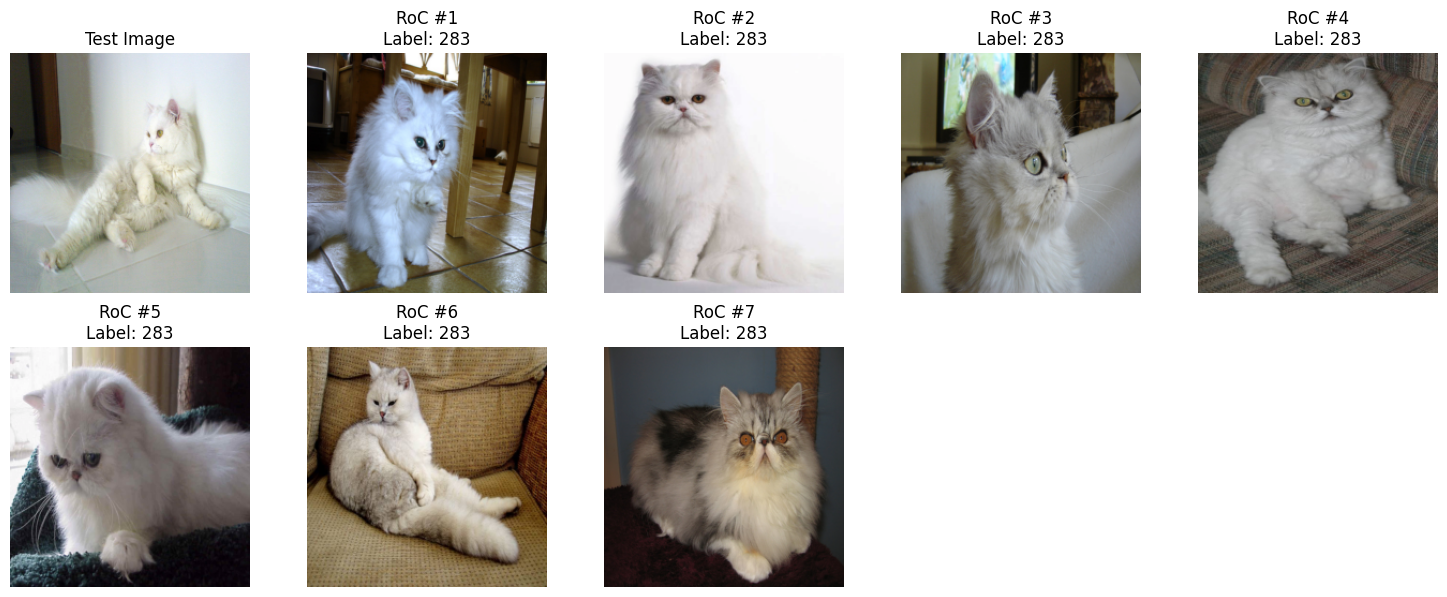

[[3170.6367 3563.88   3647.0269 3796.6602 3811.2373 3875.5317 4117.788 ]]


283

In [29]:
des_model.predict_weighted_robust(
                    adv_dataset[568][0], k=7, return_logits=False, explain=True, top=False, n=3, 
                    use_fire=False, per_class_min=1, use_sim=True, sim_threshold=0.5, 
                    alpha=0.4, knorae=False) 

In [87]:
from art.estimators.classification import EnsembleClassifier
from art.attacks.evasion import ProjectedGradientDescent

selected_pool_indices = [1, 2, 3, 4] 
# Wrap your pool into ART classifiers
art_classifiers = []
for idx in selected_pool_indices:
    model = pool[idx].to(device).eval()
    dummy_optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    
    art_clf = PyTorchClassifier(
        model=model,
        loss=loss_fn,
        optimizer=dummy_optimizer,
        input_shape=(3, 224, 224),  # <-- channels_first shape
        nb_classes=1000,
        clip_values=(0.0, 1.0),
        channels_first=True,        # <-- make it explicit
    )
    art_classifiers.append(art_clf)

# Create ensemble wrapper
ensemble_clf = EnsembleClassifier(classifiers=art_classifiers, channels_first=True )

# Run PGD on the whole ensemble
pgd_attack = ProjectedGradientDescent(estimator=ensemble_clf, eps=EPSILON, eps_step=0.01, max_iter=100)
x_test_adv_2 = pgd_attack.generate(x=x_test)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

In [88]:
adv_tensor_2 = torch.tensor(x_test_adv_2).float()
labels_tensor = torch.tensor(y_test).long()
adv_dataset_2 = TensorDataset(adv_tensor_2, labels_tensor)

adv_test_loader_2 = DataLoader(adv_dataset_2, batch_size=1, shuffle=False) 

In [91]:
_ = evaluate_classifiers(trained_pool, adv_dataset_2, 1000)

VisionTransformer: 76.21189405297352
VGG: 13.543228385807096
Inception3: 33.28335832083958
MobileNetV2: 8.095952023988005
EfficientNet: 7.496251874062969
ResNet: 59.37031484257871


In [93]:
soft_voting_metrics_attacked_2.append(predict_for_ensembles(soft_ensemble, adv_test_loader_2, "soft")) 
hard_voting_metrics_attacked_2.append(predict_for_ensembles(hard_ensemble, adv_test_loader_2, "soft"))
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader_2, "des+"))    

100%|███████████████████████████████████████████████████████████████| 2001/2001 [03:16<00:00, 10.19it/s]


soft Accuracy: 39.83%  | F1: 36.91%  | AUC: 99.71%


100%|███████████████████████████████████████████████████████████████| 2001/2001 [02:39<00:00, 12.52it/s]


soft Accuracy: 54.27%  | F1: 51.51%  | AUC: nan%


100%|███████████████████████████████████████████████████████████████| 2001/2001 [22:55<00:00,  1.45it/s]


des+ Accuracy: 58.17%  | F1: 55.28%  | AUC: 98.49%


In [94]:
from art.estimators.classification import EnsembleClassifier
from art.attacks.evasion import ProjectedGradientDescent

selected_pool_indices = [1, 2, 3, 4, 5] 
# Wrap your pool into ART classifiers
art_classifiers = []
for idx in selected_pool_indices:
    model = pool[idx].to(device).eval()
    dummy_optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    
    art_clf = PyTorchClassifier(
        model=model,
        loss=loss_fn,
        optimizer=dummy_optimizer,
        input_shape=(3, 224, 224),  # <-- channels_first shape
        nb_classes=1000,
        clip_values=(0.0, 1.0),
        channels_first=True,        # <-- make it explicit
    )
    art_classifiers.append(art_clf)

# Create ensemble wrapper
ensemble_clf = EnsembleClassifier(classifiers=art_classifiers, channels_first=True )

# Run PGD on the whole ensemble
pgd_attack = ProjectedGradientDescent(estimator=ensemble_clf, eps=EPSILON, eps_step=0.01, max_iter=100)
x_test_adv_3 = pgd_attack.generate(x=x_test)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

In [95]:
adv_tensor_3 = torch.tensor(x_test_adv_3).float()
labels_tensor = torch.tensor(y_test).long()
adv_dataset_3 = TensorDataset(adv_tensor_3, labels_tensor)

adv_test_loader_3 = DataLoader(adv_dataset_3, batch_size=1, shuffle=False) 

In [96]:
_ = evaluate_classifiers(trained_pool, adv_dataset_3, 1000) 

VisionTransformer: 75.91204397801098
VGG: 12.843578210894552
Inception3: 32.583708145927034
MobileNetV2: 7.896051974012994
EfficientNet: 8.145927036481758
ResNet: 20.789605197401297


In [97]:
soft_voting_metrics_attacked_2.append(predict_for_ensembles(soft_ensemble, adv_test_loader_3, "soft")) 
hard_voting_metrics_attacked_2.append(predict_for_ensembles(hard_ensemble, adv_test_loader_3, "soft"))
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader_3, "des+"))    

100%|███████████████████████████████████████████████████████████████| 2001/2001 [02:24<00:00, 13.87it/s]


soft Accuracy: 26.24%  | F1: 23.82%  | AUC: 99.45%


100%|███████████████████████████████████████████████████████████████| 2001/2001 [02:18<00:00, 14.41it/s]


soft Accuracy: 37.08%  | F1: 34.46%  | AUC: nan%


100%|███████████████████████████████████████████████████████████████| 2001/2001 [24:29<00:00,  1.36it/s]


des+ Accuracy: 37.88%  | F1: 35.62%  | AUC: 81.20%



Explainability Report:
Model #0: VisionTransformer
  - Competence: 1.0000
  - Feature similarity: 0.5883
  - Combined score: 0.1412
  - Combined weight: 0.3670
  - 🔥 FIRE: True
  - Predicted class: 283 with confidence 0.8326
  - Top-5: [283, 332, 258, 876, 896] → [0.833, 0.018, 0.011, 0.003, 0.002]
--------------------------------------------------
Model #1: VGG
  - Competence: 0.8571
  - Feature similarity: 0.2777
  - Combined score: 0.0000
  - Combined weight: 0.0000
  - 🔥 FIRE: True
  - Predicted class: 285 with confidence 1.0000
  - Top-5: [285, 287, 281, 282, 289] → [1.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------------------------
Model #2: Inception3
  - Competence: 0.8571
  - Feature similarity: 0.5000
  - Combined score: 0.0000
  - Combined weight: 0.0000
  - 🔥 FIRE: True
  - Predicted class: 287 with confidence 1.0000
  - Top-5: [287, 285, 281, 286, 282] → [1.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------------------------
Model #3: MobileNetV2
  - Compete

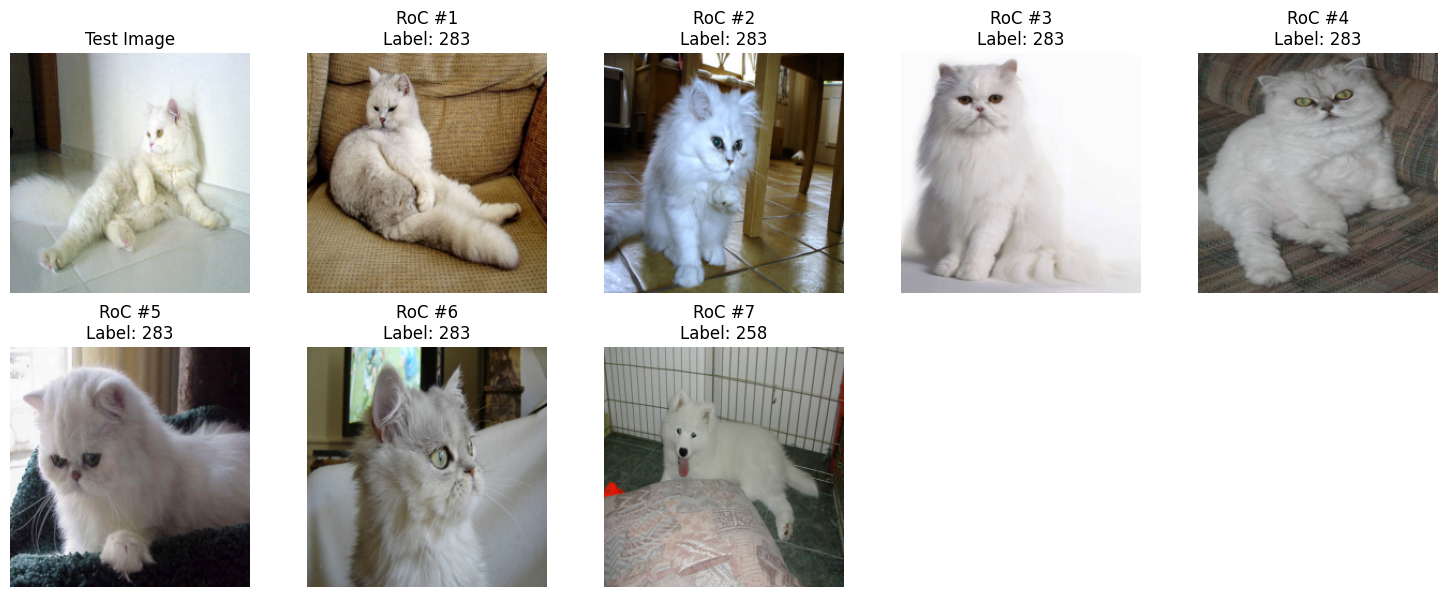

[[3021.5908 3070.0205 3130.8325 3425.771  3435.088  3457.0994 3801.2085]]


258

In [124]:
des_model.predict_weighted_robust(
                    adv_dataset_3[568][0], k=7, return_logits=False, explain=True, top=False, n=3, 
                    use_fire=False, per_class_min=1, use_sim=True, sim_threshold=0.5, 
                    alpha=0.4, knorae=False) 


Explainability Report:
Model #0: VisionTransformer
  - Competence: 1.0000
  - Feature similarity: 0.5883
  - Combined score: 0.1412
  - Combined weight: 0.5090
  - 🔥 FIRE: True
  - Predicted class: 283 with confidence 0.8326
  - Top-5: [283, 332, 258, 876, 896] → [0.833, 0.018, 0.011, 0.003, 0.002]
--------------------------------------------------
Model #1: VGG
  - Competence: 0.8571
  - Feature similarity: 0.2777
  - Combined score: 0.0000
  - Combined weight: 0.4910
  - 🔥 FIRE: True
  - Predicted class: 285 with confidence 1.0000
  - Top-5: [285, 287, 281, 282, 289] → [1.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------------------------

🧠 Final prediction: 258
🔝 Top-5 predictions:
  - Class 258: 0.4963
  - Class 283: 0.4238
  - Class 332: 0.0093
  - Class 876: 0.0016
  - Class 896: 0.0010

Model weight distribution:
  Model #0: 0.5090
  Model #1: 0.4910
Suspected attacked model: Model #4 (EfficientNet)

RoC visualization:


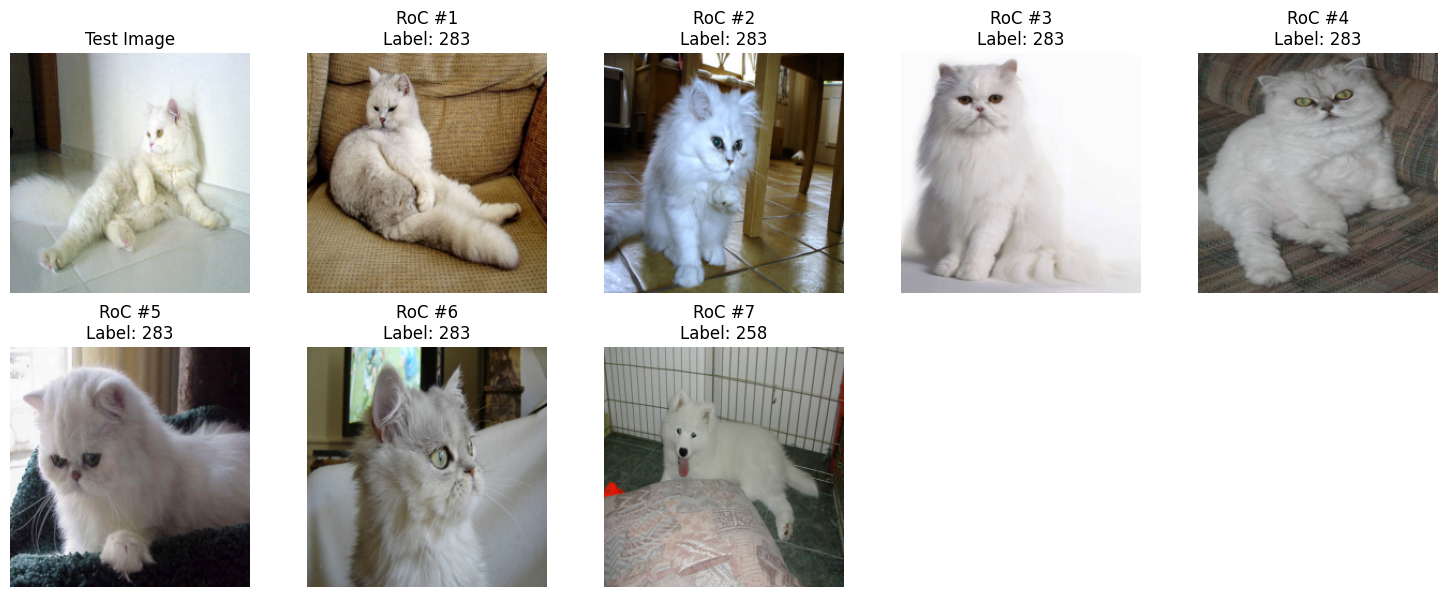

[[3021.5908 3070.0205 3130.8325 3425.771  3435.088  3457.0994 3801.2085]]


258

In [125]:
des_model.predict_weighted_robust(
                    adv_dataset_3[568][0], k=7, return_logits=False, explain=True, top=True, n=2, 
                    use_fire=False, per_class_min=1, use_sim=True, sim_threshold=0.5, 
                    alpha=0.4, knorae=False) 

In [130]:
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader, "des+"))    

100%|███████████████████████████████████████████████████████████████| 2001/2001 [24:14<00:00,  1.38it/s]


des+ Accuracy: 63.87%  | F1: 61.29%  | AUC: 99.17%


In [131]:
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader_2, "des+"))    

100%|███████████████████████████████████████████████████████████████| 2001/2001 [24:19<00:00,  1.37it/s]


des+ Accuracy: 58.72%  | F1: 56.09%  | AUC: 98.92%


In [132]:
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader_3, "des+"))    

100%|███████████████████████████████████████████████████████████████| 2001/2001 [24:23<00:00,  1.37it/s]


des+ Accuracy: 40.58%  | F1: 38.20%  | AUC: 88.79%


In [133]:
from art.estimators.classification import EnsembleClassifier
from art.attacks.evasion import ProjectedGradientDescent

selected_pool_indices = [1, 3] 
# Wrap your pool into ART classifiers
art_classifiers = []
for idx in selected_pool_indices:
    model = pool[idx].to(device).eval()
    dummy_optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    
    art_clf = PyTorchClassifier(
        model=model,
        loss=loss_fn,
        optimizer=dummy_optimizer,
        input_shape=(3, 224, 224),  # <-- channels_first shape
        nb_classes=1000,
        clip_values=(0.0, 1.0),
        channels_first=True,        # <-- make it explicit
    )
    art_classifiers.append(art_clf)

# Create ensemble wrapper
ensemble_clf = EnsembleClassifier(classifiers=art_classifiers, channels_first=True )

# Run PGD on the whole ensemble
pgd_attack = ProjectedGradientDescent(estimator=ensemble_clf, eps=EPSILON, eps_step=0.01, max_iter=100)
x_test_adv_0 = pgd_attack.generate(x=x_test)




PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

In [135]:
adv_tensor_0 = torch.tensor(x_test_adv_0).float()
labels_tensor = torch.tensor(y_test).long()
adv_dataset_0 = TensorDataset(adv_tensor_0, labels_tensor)

adv_test_loader_0 = DataLoader(adv_dataset_0, batch_size=1, shuffle=False) 

In [136]:
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader_0, "des+"))     

100%|███████████████████████████████████████████████████████████████| 2001/2001 [27:08<00:00,  1.23it/s]


des+ Accuracy: 68.57%  | F1: 66.14%  | AUC: 99.50%


In [137]:
soft_voting_metrics_attacked_2.append(predict_for_ensembles(soft_ensemble, adv_test_loader_0, "soft")) 
hard_voting_metrics_attacked_2.append(predict_for_ensembles(hard_ensemble, adv_test_loader_0, "soft"))

100%|███████████████████████████████████████████████████████████████| 2001/2001 [02:21<00:00, 14.16it/s]


soft Accuracy: 64.72%  | F1: 61.99%  | AUC: 99.81%


100%|███████████████████████████████████████████████████████████████| 2001/2001 [02:20<00:00, 14.24it/s]

soft Accuracy: 69.22%  | F1: 66.80%  | AUC: nan%


In [181]:
_ = evaluate_classifiers(trained_pool, adv_dataset_0, 1000) 

VisionTransformer: 77.56121939030484
VGG: 13.393303348325839
Inception3: 61.46926536731634
MobileNetV2: 6.696651674162919
EfficientNet: 58.220889555222385
ResNet: 66.11694152923539


In [138]:
from art.estimators.classification import EnsembleClassifier
from art.attacks.evasion import ProjectedGradientDescent

selected_pool_indices = [1] 
# Wrap your pool into ART classifiers
art_classifiers = []
for idx in selected_pool_indices:
    model = pool[idx].to(device).eval()
    dummy_optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    
    art_clf = PyTorchClassifier(
        model=model,
        loss=loss_fn,
        optimizer=dummy_optimizer,
        input_shape=(3, 224, 224),  # <-- channels_first shape
        nb_classes=1000,
        clip_values=(0.0, 1.0),
        channels_first=True,        # <-- make it explicit
    )
    art_classifiers.append(art_clf)

# Create ensemble wrapper
ensemble_clf = EnsembleClassifier(classifiers=art_classifiers, channels_first=True )

# Run PGD on the whole ensemble
pgd_attack = ProjectedGradientDescent(estimator=ensemble_clf, eps=EPSILON, eps_step=0.01, max_iter=100)
x_test_adv_4 = pgd_attack.generate(x=x_test)


adv_tensor_4 = torch.tensor(x_test_adv_4).float()
labels_tensor = torch.tensor(y_test).long()
adv_dataset_4 = TensorDataset(adv_tensor_4, labels_tensor)

adv_test_loader_4 = DataLoader(adv_dataset_4, batch_size=1, shuffle=False) 

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

In [139]:
soft_voting_metrics_attacked_2.append(predict_for_ensembles(soft_ensemble, adv_test_loader_4, "soft")) 
hard_voting_metrics_attacked_2.append(predict_for_ensembles(hard_ensemble, adv_test_loader_4, "soft"))
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader_4, "des+"))      

100%|███████████████████████████████████████████████████████████████| 2001/2001 [02:49<00:00, 11.80it/s]


soft Accuracy: 71.71%  | F1: 69.33%  | AUC: 99.87%


100%|███████████████████████████████████████████████████████████████| 2001/2001 [02:38<00:00, 12.62it/s]


soft Accuracy: 74.06%  | F1: 72.17%  | AUC: nan%


100%|███████████████████████████████████████████████████████████████| 2001/2001 [26:36<00:00,  1.25it/s]


des+ Accuracy: 72.06%  | F1: 69.83%  | AUC: 99.61%


In [184]:
_ = evaluate_classifiers(trained_pool, adv_dataset_4, 1000) 

VisionTransformer: 77.56121939030484
VGG: 5.047476261869066
Inception3: 63.8680659670165
MobileNetV2: 56.271864067966014
EfficientNet: 68.16591704147926
ResNet: 69.96501749125437


In [140]:
from art.estimators.classification import EnsembleClassifier
from art.attacks.evasion import ProjectedGradientDescent

selected_pool_indices = [0, 1, 2, 3, 4, 5] 
# Wrap your pool into ART classifiers
art_classifiers = []
for idx in selected_pool_indices:
    model = pool[idx].to(device).eval()
    dummy_optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    
    art_clf = PyTorchClassifier(
        model=model,
        loss=loss_fn,
        optimizer=dummy_optimizer,
        input_shape=(3, 224, 224),  # <-- channels_first shape
        nb_classes=1000,
        clip_values=(0.0, 1.0),
        channels_first=True,        # <-- make it explicit
    )
    art_classifiers.append(art_clf)

# Create ensemble wrapper
ensemble_clf = EnsembleClassifier(classifiers=art_classifiers, channels_first=True )

# Run PGD on the whole ensemble
pgd_attack = ProjectedGradientDescent(estimator=ensemble_clf, eps=EPSILON, eps_step=0.01, max_iter=100)
x_test_adv_all = pgd_attack.generate(x=x_test)


adv_tensor_all = torch.tensor(x_test_adv_all).float()
labels_tensor = torch.tensor(y_test).long()
adv_dataset_all = TensorDataset(adv_tensor_all, labels_tensor)

adv_test_loader_all = DataLoader(adv_dataset_all, batch_size=1, shuffle=False) 

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

In [141]:
soft_voting_metrics_attacked_2.append(predict_for_ensembles(soft_ensemble, adv_test_loader_all, "soft")) 
hard_voting_metrics_attacked_2.append(predict_for_ensembles(hard_ensemble, adv_test_loader_all, "soft"))
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader_all, "des+"))      

100%|███████████████████████████████████████████████████████████████| 2001/2001 [02:31<00:00, 13.23it/s]


soft Accuracy: 22.99%  | F1: 20.80%  | AUC: 88.13%


100%|███████████████████████████████████████████████████████████████| 2001/2001 [02:30<00:00, 13.29it/s]


soft Accuracy: 30.13%  | F1: 27.89%  | AUC: nan%


100%|███████████████████████████████████████████████████████████████| 2001/2001 [26:56<00:00,  1.24it/s]


des+ Accuracy: 35.48%  | F1: 33.32%  | AUC: 80.26%


In [183]:
_ = evaluate_classifiers(trained_pool, adv_dataset_all, 1000) 

VisionTransformer: 47.976011994002995
VGG: 12.843578210894552
Inception3: 31.984007996002
MobileNetV2: 7.246376811594203
EfficientNet: 7.34632683658171
ResNet: 20.089955022488756


### Experiment 

In [143]:
def predict_for_ensembles(ensemble_model, test_loader, ens_type): 
    metrics = {
        'accuracy': [],
        'f1': [],
        'auc': []
    } 
    y_true, y_pred, y_prob = [], [], [] 

    for imgs, labels in tqdm(test_loader):
        img = imgs[0]
        label = labels.item()

        if ens_type == "soft": 
            probs, pred = ensemble_model.predict_single_with_probs(img)
        if ens_type == "des+": 
            logits = ensemble_model.predict_weighted_robust(
                    img, k=10, return_logits=True, explain=False, top=True, n=2, 
                    use_fire=False, per_class_min=1, use_sim=True, sim_threshold=0.4, 
                    alpha=0.5, knorae=False
                )
            probs = torch.softmax(logits, dim=0).cpu().numpy()
            pred = np.argmax(probs)
    
        y_true.append(label)
        y_pred.append(pred)
        y_prob.append(probs)

    # Compute metrics
    acc = accuracy_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred, average='macro') * 100
    try:
        auc = roc_auc_score(y_true, y_prob, multi_class='ovr') * 100
    except:
        auc = float('nan')

    print(f"{ens_type} Accuracy: {acc:.2f}%  | F1: {f1:.2f}%  | AUC: {auc:.2f}%")

In [145]:
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader_all, "des+"))  

100%|███████████████████████████████████████████████████████████████| 2001/2001 [26:29<00:00,  1.26it/s]


des+ Accuracy: 37.83%  | F1: 35.41%  | AUC: 75.53%


In [146]:
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader_0, "des+"))  
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader_2, "des+"))  
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader_3, "des+"))  
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader, "des+"))  

100%|███████████████████████████████████████████████████████████████| 2001/2001 [25:53<00:00,  1.29it/s]


des+ Accuracy: 67.42%  | F1: 64.91%  | AUC: 99.12%


100%|███████████████████████████████████████████████████████████████| 2001/2001 [25:54<00:00,  1.29it/s]


des+ Accuracy: 59.12%  | F1: 56.43%  | AUC: 98.31%


100%|███████████████████████████████████████████████████████████████| 2001/2001 [26:14<00:00,  1.27it/s]


des+ Accuracy: 42.33%  | F1: 39.87%  | AUC: 81.30%


100%|███████████████████████████████████████████████████████████████| 2001/2001 [26:24<00:00,  1.26it/s]


des+ Accuracy: 63.42%  | F1: 60.61%  | AUC: 98.65%


True: 761

Explainability Report:
Model #0: VisionTransformer
  - Competence: 0.7000
  - Feature similarity: 0.5214
  - Combined score: 0.5928
  - Combined weight: 0.1694
  - 🔥 FIRE: False
  - Predicted class: 761 with confidence 0.6959
  - Top-5: [761, 528, 590, 487, 662] → [0.696, 0.123, 0.03, 0.005, 0.005]
--------------------------------------------------
Model #1: VGG
  - Competence: 0.7000
  - Feature similarity: 0.4673
  - Combined score: 0.5604
  - Combined weight: 0.1601
  - 🔥 FIRE: False
  - Predicted class: 605 with confidence 1.0000
  - Top-5: [605, 481, 448, 893, 551] → [1.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------------------------
Model #2: Inception3
  - Competence: 0.6000
  - Feature similarity: 0.6746
  - Combined score: 0.6447
  - Combined weight: 0.1842
  - 🔥 FIRE: False
  - Predicted class: 761 with confidence 0.7132
  - Top-5: [761, 401, 810, 934, 398] → [0.713, 0.256, 0.015, 0.006, 0.002]
--------------------------------------------------
Model #3: M

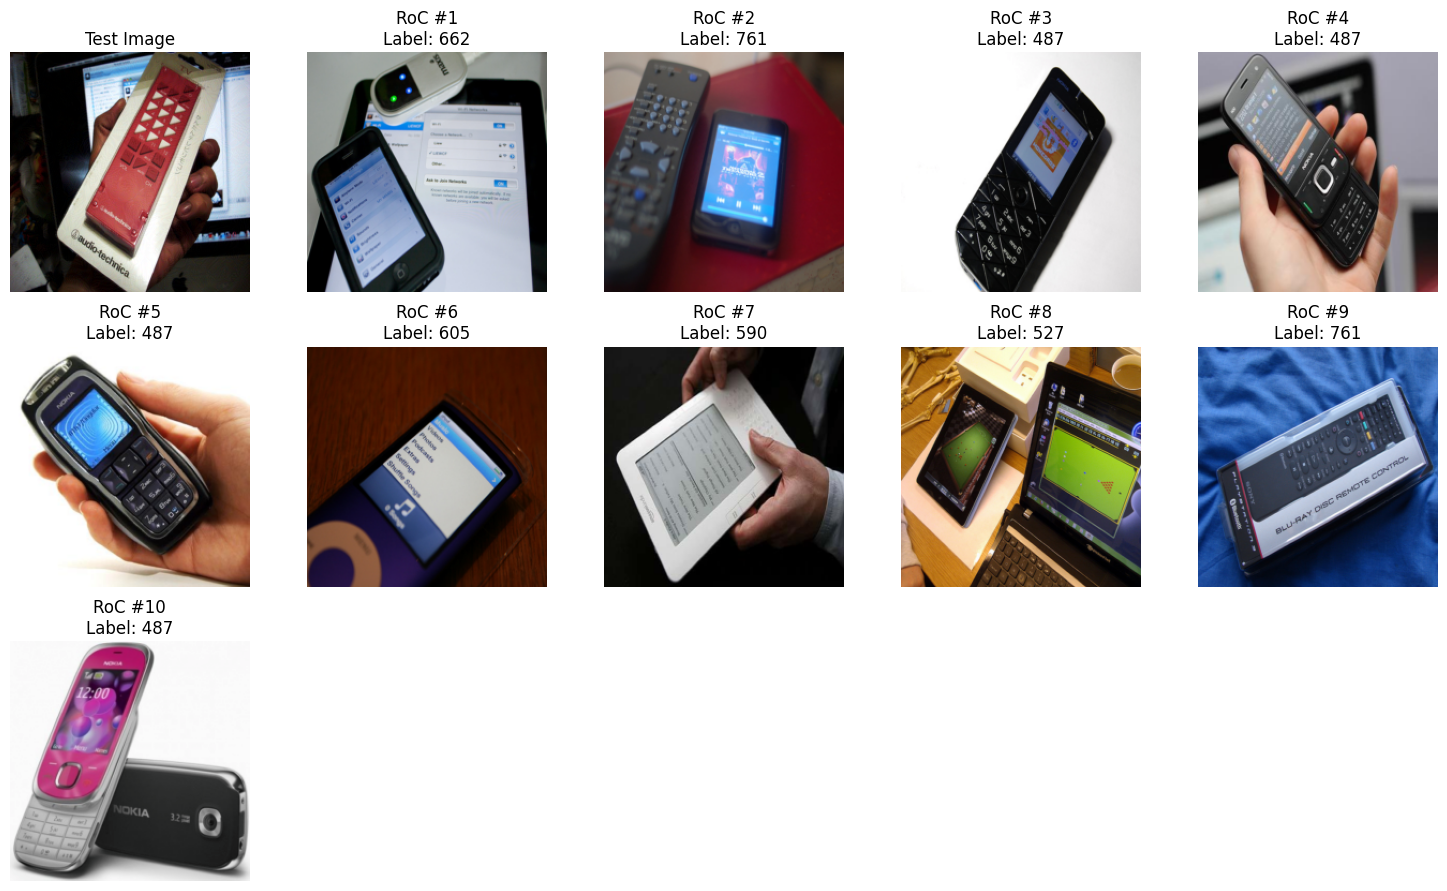

[[3218.6436 3288.3071 3437.227  3494.8037 3569.9668 3671.5444 3717.1177
  3744.3025 3757.3428 3793.8662]]


605

In [174]:
index = 1523
print(f"True: {adv_dataset_all[index][1]}")
des_model.predict_weighted_robust(
                    adv_dataset[index][0], k=10, return_logits=False, explain=True, top=False, n=2, 
                    use_fire=False, per_class_min=1, use_sim=True, sim_threshold=0.4, 
                    alpha=0.4, knorae=False)  

In [151]:
_ = evaluate_classifiers(trained_pool, adv_dataset_all, 1000)

VisionTransformer: 47.976011994002995
VGG: 12.843578210894552
Inception3: 31.984007996002
MobileNetV2: 7.246376811594203
EfficientNet: 7.34632683658171
ResNet: 20.089955022488756


In [176]:
def predict_for_ensembles(ensemble_model, test_loader, ens_type): 
    metrics = {
        'accuracy': [],
        'f1': [],
        'auc': []
    } 
    y_true, y_pred, y_prob = [], [], [] 

    for imgs, labels in tqdm(test_loader):
        img = imgs[0]
        label = labels.item()

        if ens_type == "soft": 
            probs, pred = ensemble_model.predict_single_with_probs(img)
        if ens_type == "des+": 
            logits = ensemble_model.predict_weighted_robust(
                    img, k=10, return_logits=True, explain=False, top=True, n=1, 
                    use_fire=False, per_class_min=1, use_sim=True, sim_threshold=0.4, 
                    alpha=0.5, knorae=False
                )
            probs = torch.softmax(logits, dim=0).cpu().numpy()
            pred = np.argmax(probs)
    
        y_true.append(label)
        y_pred.append(pred)
        y_prob.append(probs)

    # Compute metrics
    acc = accuracy_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred, average='macro') * 100
    try:
        auc = roc_auc_score(y_true, y_prob, multi_class='ovr') * 100
    except:
        auc = float('nan')

    print(f"{ens_type} Accuracy: {acc:.2f}%  | F1: {f1:.2f}%  | AUC: {auc:.2f}%")

In [177]:
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader_0, "des+"))  
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader_2, "des+"))  
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader_3, "des+"))  
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader_4, "des+"))  
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader, "des+"))  

100%|███████████████████████████████████████████████████████████████| 2001/2001 [26:41<00:00,  1.25it/s]


des+ Accuracy: 67.62%  | F1: 65.31%  | AUC: 97.55%


100%|███████████████████████████████████████████████████████████████| 2001/2001 [26:39<00:00,  1.25it/s]


des+ Accuracy: 61.37%  | F1: 59.24%  | AUC: 96.02%


100%|███████████████████████████████████████████████████████████████| 2001/2001 [26:46<00:00,  1.25it/s]


des+ Accuracy: 51.72%  | F1: 49.18%  | AUC: 70.76%


100%|███████████████████████████████████████████████████████████████| 2001/2001 [26:40<00:00,  1.25it/s]


des+ Accuracy: 69.57%  | F1: 67.37%  | AUC: 98.70%


100%|███████████████████████████████████████████████████████████████| 2001/2001 [27:47<00:00,  1.20it/s]


des+ Accuracy: 62.87%  | F1: 60.34%  | AUC: 97.07%


In [180]:
des_plus_metrics_attacked_2.append(predict_for_ensembles(des_model, adv_test_loader_all, "des+")) 

100%|███████████████████████████████████████████████████████████████| 2001/2001 [28:38<00:00,  1.16it/s]


des+ Accuracy: 42.53%  | F1: 40.04%  | AUC: 66.69%
